# **Librerías**
#### **Pandas**: Para crear y manejar estructuras de datos como DataFrames.
#### **Selenium**: Para automatizar la interacción con el navegador web, permitiendo navegar y extraer datos de páginas dinámicas.
#### **BeautifulSoup**: Para analizar el HTML y extraer información específica de las páginas.
#### **Requests**: Para hacer solicitudes HTTP a las páginas web y obtener el contenido.
#### **Time**: Para manejar posibles pausas entre las solicitudes.

#### **Versión de Python**: 3.12.3

In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import requests

**Configuración de Headers y URL base**  
En esta sección se define un encabezado (header) HTTP, simulando un navegador real para evitar ser bloqueados por la página. Además, se configura la URL base del catálogo de la Universidad de Antioquia. Esta URL es utilizada para buscar títulos relacionados con el tema de "Bibliotecología".

**Extracción de títulos y enlaces de las primeras 5 páginas**  
Se crean listas para almacenar los títulos y enlaces de los libros encontrados. Se utiliza un bucle para iterar sobre las primeras cinco páginas del catálogo. En cada iteración, se realiza una solicitud HTTP a la URL correspondiente, obteniendo el contenido HTML de la página.
Si la solicitud es exitosa (estado 200), se utiliza BeautifulSoup para analizar el contenido y encontrar todos los elementos que contienen títulos de libros. Luego, se extraen tanto los títulos como los enlaces a las páginas detalladas de cada libro y se almacenan en las listas.

In [ ]:
 # Configurar los headers para la solicitud HTTP
headers = { 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Base URL (sin el parámetro de paginación)
base_url = 'https://catalejo.udea.edu.co/cgi-bin/koha/opac-search.pl?advsearch=1&idx=su%2Cwrdl&q=Bibliotecolog%C3%ADa&weight_search=1&do=Buscar&sort_by=relevance'

# Lista para almacenar todos los títulos y enlaces
all_titles = []
all_links = []
# Iterar sobre las 5 primeras páginas
for page_num in range(0, 5):
    # URL con el parámetro de paginación
    url = f'{base_url}&page={page_num}' 

    # Realizar la solicitud HTTP para cada página
    response = requests.get(url, headers=headers)

    # Comprobar el estado de la respuesta
    if response.status_code == 200:
        # Crear el objeto soup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Encontrar todos los enlaces con la clase "title"
        links = soup.find_all('a', class_='title')

        # Para cada enlace, extraer el título y el enlace
        for link in links:
            title = link.get_text(strip=True)
            all_titles.append(title)

            # Extraer el enlace completo
            full_link = 'https://catalejo.udea.edu.co' + link.get('href')
            all_links.append(full_link)
    else:
        print(f"Error en la solicitud: {response.status_code}")

# Crear un DataFrame con los títulos y enlaces
df = pd.DataFrame({
    'Título': all_titles,
    'Enlace': all_links
})

# Mostrar el DataFrame
print(df)


In [ ]:
# Configuración para mostrar columnas completas sin truncar
pd.set_option('display.max_colwidth', None)

# Mostrar el DataFrame completo
print(df)

In [ ]:
# Crear una nueva lista para almacenar los autores
all_authors = []

# Iterar sobre cada enlace en el DataFrame
for link in df['Enlace']:
    # Realizar la solicitud HTTP para cada enlace
    response = requests.get(link, headers=headers)

    # Comprobar el estado de la respuesta
    if response.status_code == 200:
        # Crear el objeto soup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Buscar todos los elementos <a> con la clase "colaboradores"
        authors = []
        for author_tag in soup.find_all('a', class_='colaboradores'):
            # Extraer el nombre del autor desde la estructura HTML
            name_tag = author_tag.find('span', property='name')
            if name_tag:
                authors.append(name_tag.get_text(strip=True))
        
        if authors:
            all_authors.append(", ".join(authors))
        else:
            all_authors.append("No authors found")
    else:
        all_authors.append("No authors found")

# Añadir los autores al DataFrame
df['Autores'] = all_authors


**Uso de Selenium para extraer temas**

Selenium es utilizado para navegar a cada página de libro en el catálogo y extraer los temas relacionados con cada libro, ya que algunos elementos están cargados dinámicamente y requests no puede capturarlos directamente.
Se utiliza una espera explícita para asegurarse de que los elementos deseados (los temas) estén presentes en la página antes de proceder a extraerlos.
Finalmente, se agregan los temas a otra columna del DataFrame llamada Temas

In [ ]:
# Nota: No agregamos "--headless" para que el navegador sea visible

service = EdgeService(executable_path=r'C:\Users\Carva\Downloads\edgedriver_win64\msedgedriver.exe')
driver = webdriver.Edge(service=service, options=edge_options)

# Función para extraer temas de cada enlace
def extraer_temas(url):
    try:
        driver.get(url)
        
        # Espera explícita: espera hasta que el elemento esté presente y visible
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "span.results_summary.subjects ul.resource_list li a.asunto"))
        )
        
        # Después de que el elemento esté presente, continúa con el scraping
        temas_elements = driver.find_elements(By.CSS_SELECTOR, "span.results_summary.subjects ul.resource_list li a.asunto")
        temas = [tema.text for tema in temas_elements]
        return ', '.join(temas) if temas else 'No se encontraron temas'
    except Exception as e:
        return f'Error: {str(e)}'



# Aplicar la función a cada enlace en el DataFrame
df['Temas'] = df['Enlace'].apply(extraer_temas)

# Mostrar el DataFrame con los temas extraídos
print(df)

# Cerrar el navegador
driver.quit()

**Explicación general**:  
Este código básicamente extrae información relevante (títulos, autores y temas) de libros del catálogo en línea de la Universidad de Antioquia y la estructura en un formato fácil de manejar usando Pandas. El uso de Selenium y BeautifulSoup permite hacer scraping tanto en contenido estático como dinámico de la web.
Este tipo de scripts es útil para automatizar la recolección de grandes cantidades de datos desde una web de manera más eficiente que haciéndolo manualmente.

**(Se usó la misma estructura para scrapear la Biblioteca de Comfenalco)**


# **Librerías**
#### **pdfnumber**: Sirve para trabajar con archivos PDF, especialmente útil para extraer texto e imágenes.
#### **re**: librería de expresiones regulares para manipular texto.
#### **sklearn**: proporciona las herramientas para transformar el texto en datos cuantificables (con TfidfVectorizer) y luego comparar la similitud entre esos textos (con cosine_similarity)
#### **numpy**: Para operaciones matemáticas y de álgebra lineal.

*Extracción y Preprocesamiento del microcurriculo*

In [ ]:
import pdfplumber
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Ruta del archivo PDF
pdf_path = r'D:\Scraping\Asesoria Alejo Formato oficial de curso.pdf'

# Palabras clave para identificar las secciones
secciones_clave = ['2.', '3.', '4.', '5.']
fin_seccion_5 = '6.'
contenido_secciones = []
capturando = False

# Abrir el archivo PDF y extraer el contenido
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        texto = page.extract_text()
        
        # Dividir el texto en líneas
        lineas = texto.split('\n')
        
        # Procesar cada línea
        for linea in lineas:
            # Buscar el inicio de las secciones 2, 3, 4 y 5
            if any(linea.startswith(seccion) for seccion in secciones_clave):
                capturando = True
                contenido_secciones.append(f"--- {linea} ---")
            
            # Capturar el contenido de las secciones
            if capturando:
                contenido_secciones.append(linea)
            
            # Detener la captura al inicio de la sección 6
            if fin_seccion_5 in linea:
                capturando = False
                break

# Unir el contenido capturado en una variable
contenido_final = "\n".join(contenido_secciones)

# Frases literales a eliminar utilizando expresiones regulares
frases_a_eliminar_regex = [
    r"Describir\s+el\s+propósito\s+del\s+curso\s+en\s+relación\s+con\s+los\s+perfiles\s+del\s+programa\s+académico\..*?formación\.",
    r"Explicitar\s+los\s+elementos\s+orientadores\s+del\s+curso\s+de\s+acuerdo\s+con\s+el\s+diseño\s+curricular\s+del\s+programa\s+académico:.*?Programa\.",
    r"Describir\s+cómo\s+el\s+curso\s+hace\s+aportes\s+a\s+la\s+formación\s+integral.*?saberes\.",
    r"Explicitar\s+los\s+ejes\s+problémicos,\s+saberes,.*?programa\s+académico\."
]

# Eliminar las frases no deseadas utilizando las expresiones regulares
for frase_regex in frases_a_eliminar_regex:
    contenido_final = re.sub(frase_regex, '', contenido_final, flags=re.DOTALL)

# Lista de stopwords adicionales en español, incluyendo artículos definidos e indefinidos
stopwords_es = set(stopwords).union({'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'al', 'del'})

# Lista ampliada de stopwords en español
stopwords_es = set(stopwords).union({
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 
    'al', 'del', 'y', 'en', 'para', 'con', 'a', 'de', 'por', 
    'se', 'su', 'sus', 'que', 'qué', 'como', 'cómo', 'cuando', 
    'cuándo', 'donde', 'dónde', 'este', 'esta', 'estos', 'estas', 
    'eso', 'esa', 'esos', 'esas', 'mi', 'mis', 'tu', 'tus', 
    'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 
    'vuestra', 'vuestros', 'vuestras', 'yo', 'tú', 'él', 'ella', 
    'nosotros', 'vosotros', 'ellos', 'ellas', 'me', 'te', 'lo', 
    'le', 'les', 'nos', 'os'
})

# Preprocesar el contenido restante
def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Eliminar caracteres no deseados
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]  # Filtrar stopwords
    texto_procesado = ' '.join(palabras)
    return texto_procesado

contenido_procesado = preprocesar_texto(contenido_final)
contenido_procesado

'relaciones perfil relaciones perfil pretende formar estudiante capacidades administrativas tecnológicas gestión información través procesos automatizados sistemas información intencionalidades formativas intencionalidades formativas curso pretende desarrollar habilidades bibliotecólogo formación implementación gestión sistemas información faciliten automatización procesos servicios principalmente unidades información lograr objetivo estudiante desarrollará habilidades permitan identificar ajustes mejoras procesos actuales organización así promover implementación nuevos sistemas información faciliten prestación servicios procesos organizaciones igual forma estudiante fortalecerá capacidad identificar sistemas información diseñar nuevas arquitecturas pueda implementar organizaciones información curso también pretende formar estudiante capacidades negociación gestión proveedores sistemas información aportes curso formación integral formación investigación aportes curso formación integral

*Nube de palabras del microcurriculo*

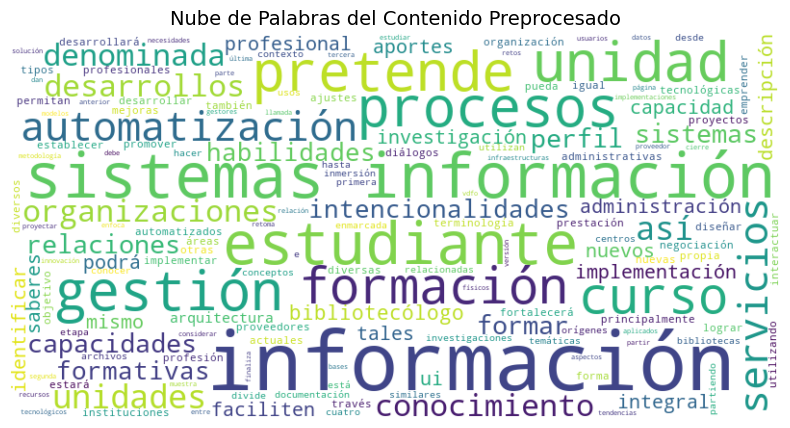

In [2]:
from wordcloud import WordCloud

# Crear una nube de palabras a partir del contenido preprocesado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(contenido_procesado)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras del Contenido Preprocesado', fontsize=14)
plt.show()


# Modelo de recomendación

In [3]:
# Cargar el archivo Excel con los documentos disponibles para recomendar
file_path = r'D:\Scraping\BD_final_con_vector_actualizado_concatenado.xlsx'
df = pd.read_excel(file_path)

# Revisar y eliminar posibles valores nulos en la columna 'Vector'
df = df.dropna(subset=['Vector'])

# Crear el TF-IDF vectorizer y entrenarlo con los textos de la columna 'Vector'
vectorizador = TfidfVectorizer()
tfidf_matriz = vectorizador.fit_transform(df['Vector'])  # Vectorizar las palabras clave de la columna 'Vector'

# Convertir el texto de entrada (contenido_procesado) al vector TF-IDF usando el mismo vectorizador
texto_vectorizado = vectorizador.transform([contenido_procesado])

# Calcular la similitud de coseno entre el vector del texto de entrada y los vectores en la BD
similaridades = cosine_similarity(texto_vectorizado, tfidf_matriz)[0]

# Ordenar por similitud y obtener las recomendaciones
indices_ordenados = np.argsort(similaridades)[::-1]

# Mostrar las 3 recomendaciones más similares
top_3_indices = indices_ordenados[:3]

# Inicializar listas para los documentos recomendados, sus similitudes y ángulos
titulos_recomendados = []
similitudes_recomendadas = []
angulos_recomendados = []

print("\nLos 3 mejores documentos recomendados son:\n")
for idx in top_3_indices:
    titulo = df.iloc[idx]['Título']
    similitud = similaridades[idx]
    
    # Calcular el ángulo en grados
    angulo = np.degrees(np.arccos(similitud))

    # Añadir a las listas para la gráfica
    titulos_recomendados.append(f"Documento {idx + 1}")
    similitudes_recomendadas.append(similitud)
    angulos_recomendados.append(angulo)

    # Mostrar el resultado en consola
    print(f"- Documento {idx + 1}: {titulo} (Similitud: {similitud:.4f}, Ángulo: {angulo:.2f}°)")



Los 3 mejores documentos recomendados son:

- Documento 200: Microcurriculo (Similitud: 0.9939, Ángulo: 6.35°)
- Documento 201: Texto espía (Similitud: 0.7034, Ángulo: 45.30°)
- Documento 98: Proyecto de gestión de la información en la Escuela de Bibliotecología y Ciencias de la Información de la Universidad de Costa Rica como apoyo a los procesos de mejoramiento continuo (Similitud: 0.2296, Ángulo: 76.72°)


# Evaluación del modelo

In [ ]:
# Definir un umbral de similitud
umbral = 0.5

# Crear etiquetas de Ground Truth simuladas (1 si similitud > umbral, 0 en caso contrario)
ground_truth_simulado = [1 if similaridad > umbral else 0 for similaridad in similaridades]

# Crear etiquetas de predicciones para las 3 mejores recomendaciones
predicciones = [1 if idx in top_3_indices else 0 for idx in range(len(df))]

# Calcular Precision, Recall y F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(ground_truth_simulado, predicciones)
recall = recall_score(ground_truth_simulado, predicciones)
f1 = f1_score(ground_truth_simulado, predicciones)

# Mostrar métricas
print("\nEvaluación del sistema de recomendaciones (Simulación):")
print(f"- Precision: {precision:.2f}")
print(f"- Recall: {recall:.2f}")
print(f"- F1-Score: {f1:.2f}")


Evaluación del sistema de recomendaciones (Simulación):
- Precision: 0.67
- Recall: 1.00
- F1-Score: 0.80


# Gráficos de los ángulos

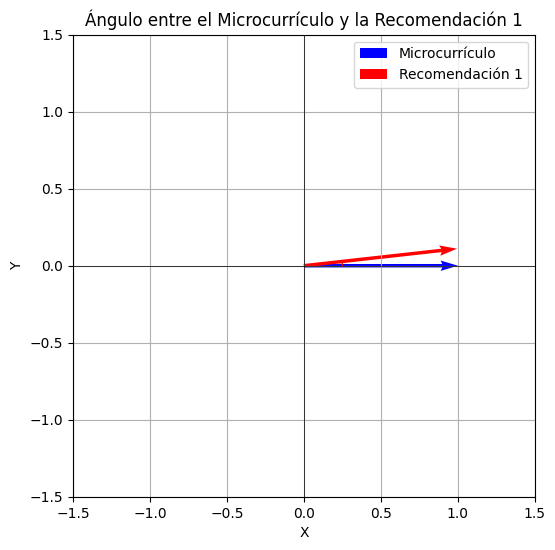

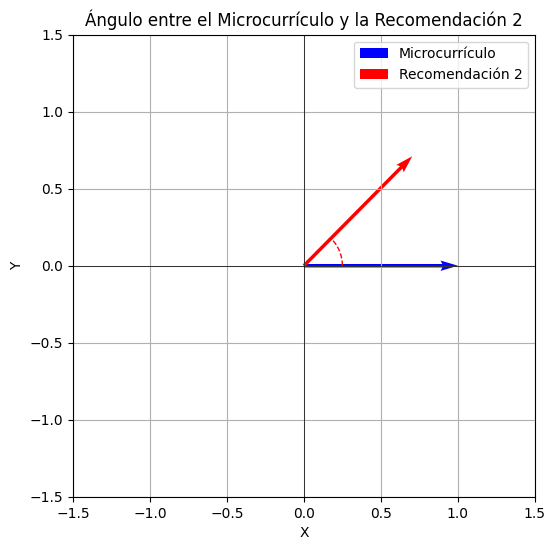

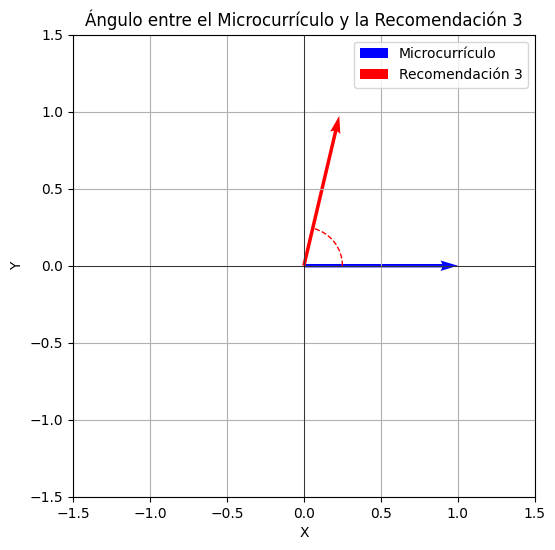

In [5]:
for i in range(3):
    plt.figure(figsize=(6, 6))

    # Vector del microcurrículo (en la dirección positiva del eje X)
    microcurriculo_vector = np.array([1, 0])  # Vector en el eje X

    # Generar el ángulo en radianes para la recomendación correspondiente
    angulo_rad = np.arccos(similitudes_recomendadas[i])
    recomendacion_vector = np.array([np.cos(angulo_rad), np.sin(angulo_rad)])  # Convertir ángulo a coordenadas (para representar en el plano)
    
    # Graficar el vector del microcurrículo
    plt.quiver(0, 0, microcurriculo_vector[0], microcurriculo_vector[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Microcurrículo', linewidth=2)
    
    # Graficar el vector de la recomendación
    plt.quiver(0, 0, recomendacion_vector[0], recomendacion_vector[1], angles='xy', scale_units='xy', scale=1, color='red', label=f'Recomendación {i + 1}', linewidth=2)
    
    # Añadir un arco que represente el ángulo
    arc_radius = 0.5  # Radio del arco
    arc = Arc((0, 0), arc_radius, arc_radius, theta1=0, theta2=np.degrees(angulo_rad), color='red', linestyle='dashed')
    plt.gca().add_patch(arc)

    # Configurar el gráfico
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ángulo entre el Microcurrículo y la Recomendación {i + 1}')
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()